# QSOs+GRBs+BAO+SNe Flat LCDM Var Ev,Om+H0,M rescaled to CMB

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.integrate
from scipy import constants
from scipy import stats
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy as sp
%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from getdist import plots, MCSamples
import getdist
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
#Here we import the matrices from SNe (Cmat) where C is the complete matrix from Dstat and Csys already inverted and for details.
#
InverseCmat=pd.read_csv("AVGCfrom1to1048ORD.txt", sep="\t", header=None)
Cinverse=np.array(InverseCmat)
Cmat=np.linalg.inv(Cinverse)
SNdata=pd.read_csv("AVGdeltamulcfrom1to1048ORD.txt", sep="\t")
#The mu_observed of the SNe are already in Mpc
zSNe=SNdata["zHD"].to_numpy()
zhel=SNdata["zhel"].to_numpy()
mb=SNdata["mu-M"].to_numpy()
dmb=SNdata["mu-M_err"].to_numpy()

In [3]:
#kLpeak

GS2data = pd.read_csv("kresultsLpeakvsOm.txt", sep="\t")


ide1 = GS2data["Om"].to_numpy()
print(ide1.size)
Om_k = GS2data["Om"].to_numpy()
kLpeak1 = GS2data["kLpeak"].to_numpy()
kLpeak1_err = (GS2data["kLpeakMax"].to_numpy()-GS2data["kLpeakMin"].to_numpy())/2

kLpeak_in = interp1d(Om_k, kLpeak1, kind='cubic')

kLpeakerr_in = interp1d(Om_k, kLpeak1_err, kind='cubic')

#kLa

GS3data = pd.read_csv("kresultsLavsOm.txt", sep="\t")


ide2 = GS3data["Om"].to_numpy()
print(ide2.size)
Om_k1 = GS3data["Om"].to_numpy()
kLa1 = GS3data["kLa"].to_numpy()
kLa1_err = (GS3data["kLaMax"].to_numpy()-GS3data["kLaMin"].to_numpy())/2

kLa_in = interp1d(Om_k, kLa1, kind='cubic')

kLaerr_in = interp1d(Om_k, kLa1_err, kind='cubic')

print(kLpeak_in(0.3),kLpeakerr_in(0.3))
print(kLa_in(0.3),kLaerr_in(0.3))

100
100
2.2365334771424594 0.29584176204615226
2.4183820425000064 0.5790086669746501


In [4]:
#Platinum Sample 
#PLATINUM 50 isotropic (only minimizer)
GS1data=pd.read_csv("platinum50.txt", sep="\t")
  
#Evolution Terms
kTa = -1.25
kTaerr = 0.28

ide=GS1data["GRBID"].to_numpy()
print(ide.size)
logF_Lp1=np.log10(GS1data["EnergyFlux"].to_numpy()) # non sono log #lo converto qui a logaritmo
logF_La1=GS1data["logFa"].to_numpy()
logF_Lp1_err=np.array(GS1data["EnergyFluxerr"].to_numpy()/(10**logF_Lp1*np.log(10)) ) # propagazione dell'errore per usare il logaritmo come variabile
logF_La1_err=(GS1data["logFa_max"].to_numpy()-GS1data["logFa_min"].to_numpy())/2
Kp=GS1data["Kprompt"].to_numpy()
Ka=GS1data["kplateau"].to_numpy()
logLp1=GS1data["logLpeak"].to_numpy()
logLa1=GS1data["logLumTa"].to_numpy()
z=GS1data["z"].to_numpy()
zGRB = GS1data["z"].to_numpy()
logTarescaled=GS1data["logTa_best"].to_numpy()-np.log10(1+z)
logTaerr=(GS1data["logTa_max"].to_numpy()-GS1data["logTa_min"].to_numpy())/2
logLp1_err=GS1data["logLpeakerr"].to_numpy()
logLa1_err=GS1data["logLumTaErr"].to_numpy()
Kp_err=GS1data["KPrompterror"].to_numpy()
Ka_err=GS1data["dk"].to_numpy()
Ta=10**(logTarescaled)
Fp=10**(logF_Lp1)
Fa=10**(logF_La1)
Lp=10**(logLp1)
La=10**(logLa1)
Ta_err=logTaerr*np.log(10)*Ta
Lp_err=logLp1_err*np.log(10)*Lp
La_err=logLa1_err*np.log(10)*La
Fa_err=logF_La1_err*np.log(10)*Fa
Fp_err=logF_Lp1_err*np.log(10)*Fp


Fpcor = Fp * Kp
Facor = Fa * Ka
Tacor = Ta/(1+z)**kTa
Fpcor_err = ((Fp * Kp_err) ** 2 + (Kp * Fp_err) ** 2) ** 0.5
Facor_err = ((Fa * Ka_err) ** 2 + (Ka * Fa_err) ** 2) ** 0.5
Tacor_err = np.sqrt(((1+z)**(-kTa)*Ta_err)**2+(-Ta*(1+z)**(-kTa)*np.log(1+z)*kTaerr)**2)
logFacor_err = Facor_err / (Facor * np.log(10))
logFpcor_err = Fpcor_err / (Fpcor * np.log(10))
logTacor_err = Tacor_err /(Tacor*np.log(10))
logFpcor = logF_Lp1 + np.log10(Kp)
logFacor = logF_La1 + np.log10(Ka)
logTacor = np.log10(Tacor)

50


In [5]:
# Import BAO Data
# rd- sound horizon size at the drag epoch, multiplied by the h=(H0/100) factor, 
# fixed to the fiducial value 104.57 for the LambdaCDM model 
# (see https://arxiv.org/pdf/1807.07323.pdf and https://arxiv.org/pdf/1506.05246.pdf). 
# The quantity is expressed in Mpc
#dz=observed of the BAO
rdfid = 104.57
dz = np.array(
    [
        0.336,
        0.2232,
        0.1905,
        0.1390,
        0.1394,
        0.1222,
        0.1239,
        0.1181,
        0.1097,
        0.1126,
        0.1161,
        0.1053,
        0.0949,
        0.0916,
        0.0874,
        0.0816,
        0.0786,
        0.0741,
        0.0739,
        0.0726,
        0.0711,
        0.0726,
        0.0675,
        0.0592,
        0.0320,
        0.0329,
    ]
)
zBAO = np.array(
    [
        0.106,
        0.15,
        0.20,
        0.275,
        0.278,
        0.31,
        0.314,
        0.32,
        0.35,
        0.35,
        0.35,
        0.36,
        0.40,
        0.44,
        0.44,
        0.48,
        0.52,
        0.56,
        0.57,
        0.57,
        0.59,
        0.60,
        0.64,
        0.73,
        2.34,
        2.36,
    ]
)
dz_err = np.array(
    [
        0.015,
        0.0084,
        0.0061,
        0.0037,
        0.0049,
        0.0021,
        0.0033,
        0.0026,
        0.0036,
        0.0022,
        0.0146,
        0.0018,
        0.0014,
        0.0071,
        0.0010,
        0.0009,
        0.0009,
        0.0008,
        0.0043,
        0.0014,
        0.0010,
        0.0034,
        0.0011,
        0.0032,
        0.0021,
        0.0017,
    ]
)
print(len(zBAO))

c33 = 30124
c39 = -17227
c99 = 86977
c1414 = 24532.1
c1422 = -25137.7
c1424 = 12099.1
c2222 = 134598.4
c2224 = -64783.9
c2424 = 128837.6
#The InvCov is listing the errors that we will be using in the chi^2.
InvCov = np.zeros((26, 26))
InvCov[2][2] = c33

i = 0
while i < len(zBAO):
    j = 0
    while j < len(zBAO):
        if i == j:
            InvCov[i][i] = 1 / dz_err[i] ** 2
        j = j + 1
    i = i + 1
InvCov[2][2] = c33
InvCov[2][8] = c39
InvCov[8][2] = c39
InvCov[8][8] = c99
InvCov[13][13] = c1414
InvCov[13][21] = c1422
InvCov[21][13] = c1422
InvCov[13][23] = c1424
InvCov[23][13] = c1424
InvCov[21][21] = c2222
InvCov[21][23] = c2224
InvCov[23][21] = c2224
InvCov[23][23] = c2424
CovBAO=np.linalg.inv(InvCov)

#o_nu
#o_b


26


In [6]:
#Import QSOs data 
QSOdata = pd.read_csv("Quasarstable.txt", sep ='\t')
print(QSOdata.columns)
print(QSOdata.head())

zQ = QSOdata['z'].to_numpy()
logFluxUVQSO = QSOdata['logFluxUV'].to_numpy()
logFluxXQSO = QSOdata['logFluxX'].to_numpy()
logFluxUVerrQSO = QSOdata['logFluxErrUV'].to_numpy()
logFluxXerrQSO = QSOdata['logFluxErrX'].to_numpy()

Index(['id', 'dk1', 'dk2', 'z', 'logFluxUV', 'logFluxErrUV', 'logFluxX',
       'logFluxErrX', 'dk3', 'dk4', 'dk5', 'dk6', 'dk7'],
      dtype='object')
                   id        dk1       dk2      z  logFluxUV  logFluxErrUV  \
0  030341.04-002321.9   45.92103  -0.38942  3.235   -27.0054        0.0373   
1  030449.85-000813.4   46.20775  -0.13708  3.296   -26.9766        0.0100   
2  090508.88+305757.3  136.28702  30.96593  3.034   -26.9725        0.0090   
3  094202.04+042244.5  145.50852   4.37902  3.284   -26.8863        0.0038   
4  094734.19+142116.9  146.89251  14.35472  3.034   -26.7802        0.0046   

   logFluxX  logFluxErrX  dk3    dk4      dk5        dk6       dk7  
0  -31.3776       0.0386    1  1.875  0.11908  46.423817  0.308447  
1  -31.2377       0.0284    1  1.988  0.29382  45.619236  0.204168  
2  -31.1391       0.0241    1  2.120  0.08832  44.985864  0.174085  
3  -31.3222       0.0480    1  2.113  0.16149  46.546097  0.330107  
4  -31.2414       0.0274    1  1.

In [7]:
#kLX

QSO2data = pd.read_csv("kresultsLXvsOm.txt", sep="\t")


ide1 = QSO2data["Om"].to_numpy()
print(ide1.size)
Om_k = QSO2data["Om"].to_numpy()
kLX1Q = QSO2data["kLX"].to_numpy()
kLX1_errQ = (QSO2data["kLXMax"].to_numpy()-QSO2data["kLXMin"].to_numpy())/2

kLX_inQ = interp1d(Om_k, kLX1Q, kind='cubic')

kLXerr_inQ = interp1d(Om_k, kLX1_errQ, kind='cubic')

#kLUV

QSO3data = pd.read_csv("kresultsLUVvsOm.txt", sep="\t")


ide2 = QSO3data["Om"].to_numpy()
print(ide2.size)
Om_k1 = QSO3data["Om"].to_numpy()
kLUV1Q = QSO3data["kLUV"].to_numpy()
kLUV1_errQ = (QSO3data["kLUVMax"].to_numpy()-QSO3data["kLUVMin"].to_numpy())/2

kLUV_inQ = interp1d(Om_k, kLUV1Q, kind='cubic')

kLUVerr_inQ = interp1d(Om_k, kLUV1_errQ, kind='cubic')

print(kLX_inQ(0.3),kLXerr_inQ(0.3))
print(kLUV_inQ(0.3),kLUVerr_inQ(0.3))

51
51
3.3598847389221196 0.06316184997558594
4.356691360473633 0.08071327209472656


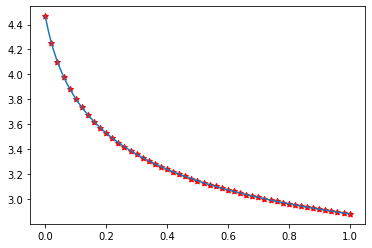

In [8]:
Om_x=np.linspace(0,1,200)
kLX_y=kLX_inQ(Om_x)

plt.plot(Om_x, kLX_y)
plt.scatter(Om_k,kLX1Q,c="r", marker=(5, 1))
plt.show()

In [9]:
Om_x=np.linspace(0,1,200)
kLUV_y=kLUV_inQ(Om_x)

plt.plot(Om_x, kLUV_y)
plt.scatter(Om_k1,kLUV1Q,c="r", marker=(5, 1))
plt.show()

## New fiducial value of M, fixing H0=67.4 from CMB

[-19.43256704]
[agostini] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {agostini: 30.2}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: M:-19.43257
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-11-27 01:42:02 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 8.336304 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence 

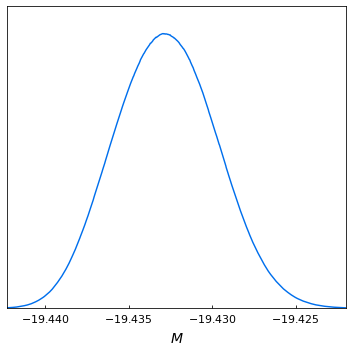

In [10]:
def my_likeSNE(M):
    
    H0=67.4 #value from CMB
    O_m=0.298 #value from Scolnic 2018
    H0_s=H0/(3.085677581491367*10**19)
    c_cm=scipy.constants.c*100 # conversione in cm, così da avere una d_L con le stesse unità del flusso
    d_par=np.array([])
    
    def integrand(r,O_m):
        return 1/(((O_m*(1+r)**3)+1-O_m))**(1/2)

    for i in zSNe:
        I=quad(integrand, 0, i, args=(O_m))
        d_par=np.append(d_par,I[0])

    d=np.array(c_cm*(1+zhel)*d_par/H0_s)
    d_megaparsec=d*(3.2408*10**(-25))

    
    logdl_th=np.log10(d_megaparsec)
    muthSNE=5*logdl_th+25
    

    mu=mb-M
    Deltamu=mu-muthSNE
    
    return(-np.sum(np.matmul(Deltamu,np.matmul(Cinverse,Deltamu))))
    
guess=-19.25            

def log_prior(array):
    M=array 
    if -20<M<-18:
        return 0.0
    return -np.inf

def log_probability(array):
    M=array
    lp = log_prior(array)
    if not np.isfinite(lp):
        return +np.inf
    return -(lp + my_likeSNE(M))

            
soln=minimize(log_probability, guess, method="SLSQP")
print(soln.x)

M=float(soln.x)

#Aggiungo al dizionario la mia likelihood.
info = {"likelihood": {"agostini": my_likeSNE}} 

from collections import OrderedDict as odict
#Carico le info relative ai parametri dentro la likelihood. 
#Ref=valore di riferimento da cui iniziare la MCMC chain, Proposa= proposto intervallo di confidenza.
info["params"] = odict([
    ["M", {"prior": {"min":-20, "max":-18},"ref":M,"proposal": 0.00001}]])

#Settaggi per far partire la catena MCMC #Accuratezza test Gelman-Rubin
info["sampler"] = {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.05, "Rminus1_cl_stop": 0.1, "learn_proposal": True}}
#info["output"] = "chains/agostini"

#Carico i settaggi che ho definito in cobaya.
from cobaya.run import run

updated_info, products = run(info)

%matplotlib inline
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamplesM1 = MCSamplesFromCobaya(updated_info, products.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamplesM1, ["M"], filled=True)

# Analyze and plot

mean = gdsamplesM1.getMeans()[:1]
var = np.sqrt(np.array(gdsamplesM1.getVars()[:1]))

print("Mean:")
print(mean)
print("Variances")
print(var)


# Distance moduli likelihood for GRBs_Om+H0_VarEv

In [11]:
#We here define the sum of the likelihood
#we first define the constant
co=299792.458 #this is speed of light in km/s
ckm = 299742.458
NGRB=50
NSNe=1048
NBAO=26
#The conversion from cm to Megaparsec 1Mpc=3.08567758*10^24 cm.
#rs is the  and it is taken from Equation of the paper of Sharov 2018
# rs is the numerically calibrated approximation of rd (following https://arxiv.org/pdf/1411.1074.pdf)
# o_nu neutrinos fraction (https://arxiv.org/pdf/1411.1074.pdf)
# o_b baryonic fraction (https://arxiv.org/pdf/1411.1074.pdf)
o_nu = 0.00064
o_b = 0.02237
# this factor takes into consideration of the conversion of the units from cm to Mpc it is c/H0 in Mpc np.log10(3.08567758*10**24*(1+zGRB))#
#this is the definition of the distance moduli in Mpc see Equation 7 of Postnikov et al. 2014
# This is the observed distance moduli of GRBs and SNe.
# the 1/integrand=H/H0--> H=H0/integrand from Sharov 2018 Equation 5: H^2=H0^2*((1 + r) ** 3 * O_m + O_l)) -->H=Ho/integrand  
#Dv= (c*z DL^2 /(1+z)^2 *H(z))^1/3 equation 11 of https://arxiv.org/pdf/1807.07323.pdf
#Dv= (c*z DL^2 integrand/(1+z)^2 *H0)^1/3
conversionfrom_cm_to_Mpc=3.08567758*10**24

M=gdsamplesM1.getMeans()[:1] #new M from previous fit


def integrand(r, O_m, O_l):
    return 1/ (((1 + r) ** 3 * O_m + O_l) ** (1 / 2))

def my_like(a, b, sv, g1, n1, sv1,  O_m, H0):
    
    HoMx=H0 #this is in Mpc
    h = H0 / 100
    
    coefGRB=(co/HoMx)*(1+zGRB)
    coefSNe=(co/HoMx)*(1+zhel)
    coefBAO=(co/HoMx)*(1+zBAO)
    coefQ=(co/HoMx)*(1+zQ)
    
    O_l = 1 - O_m
    
    logFpcorV=logFpcor-kLpeak_in(O_m)*np.log10(1+zGRB)
    logFacorV=logFacor-kLa_in(O_m)*np.log10(1+zGRB)
    logFpcorV_err=np.sqrt(logFpcor_err**2 + (kLpeakerr_in(O_m)*np.log10(1+zGRB))**2)
    logFacorV_err=np.sqrt(logFacor_err**2 + (kLaerr_in(O_m)*np.log10(1+zGRB))**2)

    c = 23
    a1 = a / (2 * (1 - b))
    b1 = b / (2 * (1 - b))
    c1 = (np.log10(4 * np.pi) * (b - 1) + c) / (2 * (1 - b))
    d1 = -1.0 / (2 * (1 - b))
    d_parGRB = np.array([])
    d_parSNe= np.array([])
    d_parBAO = np.array([])
    d_parQSO = np.array([])
    dzth = np.array([])
    rs = (55.154 * np.exp(-72.3 * (o_nu + 0.0006) ** 2) / ((O_m * h ** 2) ** 0.25351 * (o_b ** 0.12807)))
        
    for i in zSNe:
        I= quad(integrand, 0, i, args=(O_m, O_l))
        d_parSNe = np.append(d_parSNe, I[0])

    for i in zGRB:
        I = quad(integrand, 0, i, args=(O_m, O_l))
        d_parGRB = np.append(d_parGRB, I[0])

    for z in zBAO:
        IBAO = quad(integrand, 0, z, args=(O_m, O_l))
        d_parBAO = np.append(d_parBAO, IBAO[0])
        #D_L = (ckm*(1+z)*IBAO[0])/H0
        #Dv = ((ckm * z * (D_L)**2*IBAO[0]) / ((1+z)**2*H0)) ** (1 / 3)
        
    for i in zQ:
        I = quad(integrand, 0, i, args=(O_m, O_l))
        d_parQSO = np.append(d_parQSO, I[0])
    
       
    D_L=coefBAO* d_parBAO
    Dv = ((ckm * zBAO * (D_L)**2*integrand(zBAO, O_m, O_l)) / ((1+zBAO)**2*H0)) ** (1 / 3)
    dzth = rs / Dv
    #dzth = np.append(dzth, dzval)

    dBAO = np.array(coefBAO* d_parBAO)
    dSNe = np.array(coefSNe* d_parSNe)
    dGRB = np.array(coefGRB* d_parGRB)
    dQ = np.array(coefQ*d_parQSO)
    
    logLumUVQSO = logFluxUVQSO + np.log10(4*np.pi*dQ**2) + 2*np.log10(conversionfrom_cm_to_Mpc) - kLUV_inQ(O_m) * np.log10(1+zQ)
    logLumXQSO = logFluxXQSO + np.log10(4*np.pi*dQ**2) + 2*np.log10(conversionfrom_cm_to_Mpc) - kLX_inQ(O_m) * np.log10(1+zQ)
    logLumUVerrQSO = np.sqrt(logFluxUVerrQSO**2 + (np.log10(1+zQ)*kLUVerr_inQ(O_m))**2 )
    logLumXerrQSO = np.sqrt(logFluxXerrQSO**2 + (np.log10(1+zQ)*kLXerr_inQ(O_m))**2 )
    
    logLumXthQSO = g1 * logLumUVQSO + n1 
    
    sv_L_sqQSO = g1**2 * logLumUVerrQSO**2 + logLumXerrQSO**2 + sv1**2
    
#The theoretical distance luminosity below is in Megaparsec and the distance moduli in Mpc

    logdl_thSNe = np.log10(dSNe)
    logdl_thGRB=np.log10(dGRB)
    logdl_thBAO=np.log10(dBAO)
    muthSNe = 5 * logdl_thSNe + 25
    muthGRB=5 * logdl_thGRB + 25
    muthBAO = 5 * logdl_thBAO + 25
    Deltadz = dzth - dz
    
    logint_obGRB = (logTacor * a1) + (logFpcorV * b1) + c1 + (d1 * logFacorV) - np.log10(conversionfrom_cm_to_Mpc)
#Here we define the error on the distance luminosity for GRBs for a given cosmology, Om=0.311 and H0=70, the complete formula
#but we here remove all the error on the parameters and we fix the c parameter.
#logint_obGRBerr=np.sqrt((logTaerr * a1)**2 + (logFpcor_err * b1)**2 + (d1 * logFacor_err)**2+ 
#(logTarescaled*a1err)**2+(logFpcor*b1err)**2+(logFacor*d1err)**2+(c1err)**2)

    #logint_obGRBerr=np.sqrt((logTaerr * a1)**2 + (logFp_err * b1)**2 + (d1 * logFacor_err)**2+ 
    #(logTarescaled*a1err)**2+(logFpcor*b1err)**2+(logFacor*d1err)**2)
    mu_obGRB=5*logint_obGRB+25
    #mu_obGRB_err=5*logint_obGRBerr
    mu_obSNe=mb-M

#Here the intrinsic scatter on GRBs is added and it should not consider the parameters of the planes errors, since they are
#derived by the MCMC
    sv_muobGRB = np.sqrt((5 * a1 * logTacor_err) ** 2 + (5 * b1 * logFpcorV_err) ** 2 + (5 * d1 * logFacorV_err) ** 2
    + 5**2 * sv ** 2)

# Now we define the chi^2
    chi2_GRB =np.sum(((muthGRB - mu_obGRB)/(sv_muobGRB))**2)
    chi2_SNe =np.matmul((muthSNe - mu_obSNe),np.matmul(Cinverse,(muthSNe - mu_obSNe)))
    chi2_BAO=np.matmul(Deltadz, np.matmul(InvCov, Deltadz))
    chi2Q = np.sum((logLumXthQSO-logLumXQSO)**2/sv_L_sqQSO)

# Now we define the chi^2 for SNe; since SNe have a covariance matrix that includes both statistical uncertainties on the
# diagonal and systematic uncertainties in the non-diagonal positions, the chi^2 will be in the form of
# deltamu(vector,transposed)*Covariance_matrix(already_inverted_in_the_importation)*deltamu(vector)
#  loglikelihood is defined in equation 35 of Postkinov et al. (2014). 
# 1) f(y)=e^(-((y-yi)/Deltayi)^2)/2)/(SQRT(2pi)*Deltayi).
# We remind that chi^2=(y-yi)/Deltayi)^2 so we substitute in 1) and we obtain 
# f(y)=e^((-chi^2)/2)/(SQRT(2pi)*Deltayi)
#We take the loglikelihood defined in Dainotti al. 2013 https://arxiv.org/pdf/1308.1918.pdf equation 2 and we use for the GRBs only
# We cannot neglect the term of sigma because it contains the cosmological parameters.
#likelihood=1/((2*np.pi)**(NGRB/2)*sv_muobGRB)*exp(-chi2_GRB/2). Then we do the ln.

    loglikeGRB= -np.sum(np.log(sv_muobGRB)) -(1/2)*chi2_GRB
    #loglikeGRB=np.log(1/(2 *np.pi)**(NGRB/2))+np.log(np.sum(1/sv_muobGRB)) -np.sum((1/2)*chi2_GRB)
    loglikeBAO=-(1/2)*chi2_BAO
    loglikeSNe=-(1/2)*chi2_SNe
    loglikeQ = - (1/2)*np.sum(np.log(sv_L_sqQSO)) - (1/2)*chi2Q
    logliketotal=loglikeGRB+loglikeSNe+loglikeBAO+loglikeQ
    return(logliketotal)

   
guess=[-1.0, 0.5, 0.34, 0.65792432, 6.55498807, 0.2314415, 0.3, 70]

def log_prior(array):
    a,b,sv,g1,n1,sv1,O_m,H0=array
    if  -2<a<0 and 0<b<2 and 0<sv<7 and 0<O_m<1 and 0<g1<1 and 4<n1<8 and 0<sv1<1 and 50<H0<100:
        return 0.0
    return -np.inf

def log_probability(array):
    a,b,sv,g1,n1,sv1,O_m,H0=array
    lp = log_prior(array)
    if not np.isfinite(lp):
        return +np.inf
    return -(lp + my_like(a,b,sv,g1,n1,sv1,O_m,H0))

soln=minimize(log_probability, guess, method="SLSQP")
print(soln.x)

#H0=soln.x
a,b,sv,g1,n1,sv1,O_m,H0=guess

#likelihood.
info = {"likelihood": {"agostini": my_like}} 

from collections import OrderedDict as odict
#info related to the parameters inside the likelihood 
#Ref = reference value from which to start the MCMC chain, proposed confidence interval
info["params"] = odict([
    ["a", {"prior": {"min":-2, "max":0},"ref":a,"proposal": 0.001}],
    ["b", {"prior": {"min":0, "max":2},"ref":b,"proposal": 0.001}],
    ["sv", {"prior": {"min":0, "max":2.7},"ref":sv,"proposal": 0.001}],
    ["g1", {"prior": {"min":0.4, "max":0.8},"ref":g1,"proposal": 0.001, "latex": r"g_1"}],
    ["n1", {"prior": {"min":2, "max":20},"ref":n1,"proposal": 0.001, "latex": r"n_1"}],
    ["sv1", {"prior": {"min":0, "max":2},"ref":sv1,"proposal": 0.001, "latex": r"sv_1"}],
    ["O_m", {"prior": {"min":0, "max":1},"ref":O_m,"proposal": 0.001, "latex": r"\Omega_M"}],
    ["H0", {"prior": {"min":50, "max":100},"ref":H0,"proposal": 0.001, "latex": r"H_0"}]])


#Settings to start the MCMC chain # Gelman-Rubin test accuracy
info["sampler"] = {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.05, "Rminus1_cl_stop": 0.1, "learn_proposal": True}}
#info["output"] = "chains/agostini"

#load the settings defined in cobaya
from cobaya.run import run

updated_info, products = run(info)

%matplotlib inline
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples = MCSamplesFromCobaya(updated_info, products.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.settings.lab_fontsize = 20
gdplot.settings.axes_fontsize = 15
gdplot.triangle_plot(gdsamples, ["a", "b", "sv", "g1", "n1", "sv1", "O_m","H0"], filled=True)
gdplot.export('SNe+BAO+GRB(DM)+QSO_Varying_O_m+H0_VarEv_MrescaledtoCMB.pdf')


# Analyze and plot

mean = gdsamples.getMeans()[:8]
sigma = np.sqrt(np.array(gdsamples.getVars()[:8]))
covmat = gdsamples.getCovMat().matrix[:8, :8]


print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat)



[-0.77526192  0.53091535  0.19663339  0.6011788   7.9999986   0.22561154
  0.28001567 67.70631495]
[agostini] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {agostini: 7.67}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:-1, b:0.5, sv:0.34, g1:0.6579243, n1:6.554988, sv1:0.2314415, O_m:0.3, H0:70
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-11-27 01:44:46 : 1 steps taken -- still burning in, 301 accepted steps left.
[mcmc] Progress @ 2022-11-27 01:45:46 : 458 steps taken -- still burning in, 163 accepted steps left.
[mcmc] Progress @ 2022-11-27 01:46:47 : 911 steps taken -- still burning in, 41 accepted steps left.
[mcmc] Finished burn-in phase

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-11-27 02:30:49 : 21468 steps taken, and 5773 accepted.
[mcmc] Progress @ 2022-11-27 02:31:50 : 21958 steps taken, and 5934 accepted.
[mcmc] Progress @ 2022-11-27 02:32:50 : 22455 steps taken, and 6067 accepted.
[mcmc] Learn + convergence test @ 6080 samples accepted.
[mcmc]  - Acceptance rate: 0.266
[mcmc]  - Convergence of means: R-1 = 0.068011 after 4864 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-11-27 02:33:50 : 22944 steps taken, and 6208 accepted.
[mcmc] Progress @ 2022-11-27 02:34:50 : 23434 steps taken, and 6366 accepted.
[mcmc] Learn + convergence test @ 6400 samples accepted.
[mcmc]  - Acceptance rate: 0.267
[mcmc]  - Convergence of means: R-1 = 0.083415 after 5120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-11-27 02:35:50 : 23924 steps taken, and 6510 accepted.
[mcmc] Progress @ 2022-11-27 02:36:50 : 24444 s

In [12]:
my_like

<function __main__.my_like(a, b, sv, g1, n1, sv1, O_m, H0)>

In [13]:
print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat)

Mean:
[-0.75904821  0.52924478  0.21557246  0.59329589  8.22782093  0.22543731
  0.28021652 67.66102524]
1 sigma:
[0.09679162 0.00722998 0.0711245  0.01109168 0.32046963 0.0035727
 0.00677347 0.14534456]
Covariance matrix:
[[ 9.36861811e-03 -6.92291939e-04  9.23185595e-04 -2.15643618e-05
   6.22332990e-04  4.71353406e-07  1.16738726e-05  3.71548105e-04]
 [-6.92291939e-04  5.22725799e-05 -6.63041576e-05  1.08792275e-06
  -3.12870864e-05 -2.34255793e-07 -1.14225316e-06 -2.59006233e-05]
 [ 9.23185595e-04 -6.63041576e-05  5.05869476e-03 -2.33394373e-05
   6.53662755e-04  5.17285597e-06 -1.67577467e-05  2.37893469e-04]
 [-2.15643618e-05  1.08792275e-06 -2.33394373e-05  1.23025369e-04
  -3.55413456e-03  2.35738859e-06  1.93259310e-06 -2.86124355e-05]
 [ 6.22332990e-04 -3.12870864e-05  6.53662755e-04 -3.55413456e-03
   1.02700787e-01 -6.78748564e-05 -5.41820789e-05  7.01826716e-04]
 [ 4.71353406e-07 -2.34255793e-07  5.17285597e-06  2.35738859e-06
  -6.78748564e-05  1.27641824e-05 -6.39819939e